In [32]:
import pandas as pd
import numpy as np
import random
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt
from google.cloud import storage
from io import BytesIO
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO

In [2]:
%pwd

'/Users/maxgrossenbacher/Documents/DELVE_projects/Expedia_hotel_recommendation_kaggle/notebooks'

In [3]:
destination_df = pd.read_csv('../data/destinations.csv')

In [4]:
test_df = pd.read_csv('../data/test.csv')

In [5]:
train_df = pd.read_csv('../data/train.csv')

In [6]:
test_df["date_time"] = pd.to_datetime(test_df["date_time"])
test_df["year"] = test_df["date_time"].dt.year
test_df["month"] = test_df["date_time"].dt.month

train_df["date_time"] = pd.to_datetime(train_df["date_time"])
train_df["year"] = train_df["date_time"].dt.year
train_df["month"] = train_df["date_time"].dt.month

In [7]:
#check number of unique user_ids
print('{} unique users training data'.format(train_df['user_id'].nunique()))
#check is user_ids in test is the same as user_ids in train
train_ids = set(train_df['user_id'].unique())
test_ids = set(test_df['user_id'].unique())
intersection_count = len(train_ids & test_ids)
print('{}: the user_id in train set the same as the user_id in test set.' .format(
    intersection_count == len(test_ids)))

1198786 unique users training data
True: the user_id in train set the same as the user_id in test set.


In [8]:
# check the date in train vs test set
print('The min year in the train set is {}.'.format(train_df['year'].min()))
print('The max year in the train set is {}.'.format(train_df['year'].max()))
print('The min year in the test set is {}.'.format(test_df['year'].min()))
print('The max year in the test set is {}.'.format(test_df['year'].max()))

The min year in the train set is 2013.
The max year in the train set is 2014.
The min year in the test set is 2015.
The max year in the test set is 2015.


#### Sample Data

In [9]:
unique_users = set(train_df['user_id'].unique())

sel_user_ids = random.sample(unique_users,10000)
sample_train_df = train_df[train_df.user_id.isin(sel_user_ids)]

In [10]:
sample_train_df.to_csv('../data/sampled_data.csv')

In [11]:
# sample_train_df = pd.read_csv('../data/sampled_data.csv')
# sample_train_df.drop('Unnamed: 0', inplace=True, axis=1)

sample_train_df["date_time"] = pd.to_datetime(sample_train_df["date_time"])
sample_train_df["year"] = sample_train_df["date_time"].dt.year
sample_train_df["month"] = sample_train_df["date_time"].dt.month

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [12]:
t1 = sample_train_df[((sample_train_df.year == 2013) | ((sample_train_df.year == 2014) & (sample_train_df.month < 7)))]
# t2 is new test set for validation of model
t2 = sample_train_df[((sample_train_df.year == 2014) & (sample_train_df.month >= 7))]
# t2 is new test set for validation of model
t3 = sample_train_df[((sample_train_df.year == 2014) & (sample_train_df.month >= 8))]

In [13]:
# only keep booking events in new test set because needs to be consistent with the test set provided
print('Number of events Validation Set (ALL): ', t2.shape[0])
t2 = t2[t2['is_booking']==True]
print('Number of booking events Validation Set: ', t2.shape[0])

print('Number of events Test set (ALL): ', t3.shape[0])
t3 = t3[t3['is_booking']==True]
print('Number of booking events Test set: ', t3.shape[0])

Number of events Validation Set (ALL):  140010
Number of booking events Validation Set:  9817
Number of events Test set (ALL):  117224
Number of booking events Test set:  8228


### 5 Most Common

In [14]:
most_common_clusters = list(train_df['hotel_cluster'].value_counts().index)[:5]
print('Number unique hotel clusters: ', train_df['hotel_cluster'].nunique())
print('5 most common hotel clusters: ',most_common_clusters)

Number unique hotel clusters:  100
5 most common hotel clusters:  [91, 41, 48, 64, 65]


In [15]:
baseline_predictions = [most_common_clusters for i in range(t3.shape[0])]
print(len(baseline_predictions))

8228


In [16]:
# functions for evaluation metrics (mean absolute precision)
import numpy as np

def apk(actual, predicted, k=5):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)
  

def mapk(actual, predicted, k=5):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [17]:
target = [[l] for l in t3['hotel_cluster']]
print(target[:5])

[[36], [26], [65], [89], [18]]


In [18]:
baseline_score = mapk(target, baseline_predictions, k=5)
print('Baseline Mean Absolute Precision: ', baseline_score)

Baseline Mean Absolute Precision:  0.06398476746070329


### Feature Generation

In [19]:
# check if any correlation between features and target -- no strong correlation present
train_df.corr()['hotel_cluster']

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
year                        -0.001050
month                       -0.000560
Name: hotel_cluster, dtype: float64

In [20]:
# PCA dimensionality redunction on destination features
from sklearn.decomposition import PCA

variance = []
components = [15]
for x in components:
    pca = PCA(n_components=x)
    destinations_pca = pca.fit_transform(destination_df[['d{0}'.format(i+1) for i in range(149)]])
    for ev in pca.explained_variance_ratio_:
        variance.append(ev)
    print('Component:\t\t{}\nExplained Variance:\t{}\n'.format(x, pca.explained_variance_ratio_))

Component:		15
Explained Variance:	[0.46106252 0.10834396 0.04631931 0.02508245 0.02338351 0.02127207
 0.01691681 0.0151513  0.01439311 0.01238453 0.01155595 0.01113085
 0.01036317 0.00947365 0.00924669]



[0.46106251738967857, 0.10834395687087972, 0.04631930631532237, 0.02508245031637978, 0.02338350549819944, 0.02127207385107214, 0.016916807327748588, 0.015151301616054505, 0.01439311099878709, 0.012384534312167201, 0.011555945960997188, 0.011130851623614503, 0.010363169221056276, 0.009473649106935931, 0.009246690277109375]


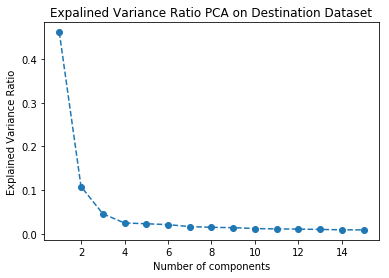

In [21]:
c = [i+1 for i in range(15)]
plt.plot(c, variance, 'o--')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.title('Expalined Variance Ratio PCA on Destination Dataset')
print(variance)

In [22]:
# optimial to use 4 components (accounts for 65% of variance in 149 original columns)
pca = PCA(n_components=4)
destinations_pca = pca.fit_transform(destination_df[['d{0}'.format(i+1) for i in range(149)]])
destinations_pca_df = pd.DataFrame(destinations_pca)
destinations_pca_df['srch_destination_id'] = destination_df['srch_destination_id']
destinations_pca_df.head()

,0,1,2,3,srch_destination_id
0,-0.044268,0.169419,0.032527,-0.014305,0
1,-0.440761,0.077405,-0.091572,-0.020201,1
2,0.001033,0.020677,0.012107,0.134108,2
3,-0.480467,-0.040345,-0.019319,-0.040102,3
4,-0.207253,-0.042694,-0.011744,-0.017541,4


In [23]:
def feature_generation(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")

    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)

    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]

    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')

    ret = pd.DataFrame(props)

    ret = ret.join(destinations_pca_df, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_iddest", axis=1)
    return ret

In [24]:
train = feature_generation(t1)
val = feature_generation(t2)
test = feature_generation(t3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [25]:
y_train = train.pop('hotel_cluster')
X_train = train
features = train.columns

y_val = val.pop('hotel_cluster')
X_val = val

y_test = test.pop('hotel_cluster')
X_test = test

In [26]:
model = xgb.XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train[features], y_train,
          early_stopping_rounds=100,
          eval_set=[(X_train[features], y_train), (X_val[features], y_val)],
          eval_metric='mlogloss',
          verbose=True)

[0]	validation_0-mlogloss:4.43915	validation_1-mlogloss:4.48781
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:4.35153	validation_1-mlogloss:4.4157
[2]	validation_0-mlogloss:4.28225	validation_1-mlogloss:4.3563
[3]	validation_0-mlogloss:4.22423	validation_1-mlogloss:4.30496
[4]	validation_0-mlogloss:4.17521	validation_1-mlogloss:4.26217
[5]	validation_0-mlogloss:4.13143	validation_1-mlogloss:4.22232
[6]	validation_0-mlogloss:4.09257	validation_1-mlogloss:4.18669
[7]	validation_0-mlogloss:4.05727	validation_1-mlogloss:4.15466
[8]	validation_0-mlogloss:4.026	validation_1-mlogloss:4.12632
[9]	validation_0-mlogloss:3.9964	validation_1-mlogloss:4.10002
[10]	validation_0-mlogloss:3.96912	validation_1-mlogloss:4.07529
[11]	validation_0-mlogloss:3.94361	validation_1-mlogloss:4.05152
[12]	validation_0-mlogloss:3.92037	validation_1-mlogloss:4.03017
[1

[124]	validation_0-mlogloss:3.27508	validation_1-mlogloss:3.59131
[125]	validation_0-mlogloss:3.27247	validation_1-mlogloss:3.59053
[126]	validation_0-mlogloss:3.27004	validation_1-mlogloss:3.58998
[127]	validation_0-mlogloss:3.26768	validation_1-mlogloss:3.58938
[128]	validation_0-mlogloss:3.26534	validation_1-mlogloss:3.58853
[129]	validation_0-mlogloss:3.26292	validation_1-mlogloss:3.5879
[130]	validation_0-mlogloss:3.26066	validation_1-mlogloss:3.5873
[131]	validation_0-mlogloss:3.25819	validation_1-mlogloss:3.58679
[132]	validation_0-mlogloss:3.25594	validation_1-mlogloss:3.58627
[133]	validation_0-mlogloss:3.2534	validation_1-mlogloss:3.58536
[134]	validation_0-mlogloss:3.251	validation_1-mlogloss:3.58483
[135]	validation_0-mlogloss:3.24847	validation_1-mlogloss:3.5842
[136]	validation_0-mlogloss:3.24612	validation_1-mlogloss:3.58368
[137]	validation_0-mlogloss:3.24397	validation_1-mlogloss:3.58305
[138]	validation_0-mlogloss:3.24172	validation_1-mlogloss:3.58259
[139]	validation

[249]	validation_0-mlogloss:3.03564	validation_1-mlogloss:3.53432
[250]	validation_0-mlogloss:3.03412	validation_1-mlogloss:3.53401
[251]	validation_0-mlogloss:3.03254	validation_1-mlogloss:3.53353
[252]	validation_0-mlogloss:3.03098	validation_1-mlogloss:3.53321
[253]	validation_0-mlogloss:3.02938	validation_1-mlogloss:3.53285
[254]	validation_0-mlogloss:3.02795	validation_1-mlogloss:3.53273
[255]	validation_0-mlogloss:3.02638	validation_1-mlogloss:3.53242
[256]	validation_0-mlogloss:3.02483	validation_1-mlogloss:3.53206
[257]	validation_0-mlogloss:3.02332	validation_1-mlogloss:3.5318
[258]	validation_0-mlogloss:3.0219	validation_1-mlogloss:3.53153
[259]	validation_0-mlogloss:3.02045	validation_1-mlogloss:3.53138
[260]	validation_0-mlogloss:3.01905	validation_1-mlogloss:3.5311
[261]	validation_0-mlogloss:3.01758	validation_1-mlogloss:3.53079
[262]	validation_0-mlogloss:3.01605	validation_1-mlogloss:3.53057
[263]	validation_0-mlogloss:3.01453	validation_1-mlogloss:3.5304
[264]	validati

[374]	validation_0-mlogloss:2.8646	validation_1-mlogloss:3.50813
[375]	validation_0-mlogloss:2.86349	validation_1-mlogloss:3.50792
[376]	validation_0-mlogloss:2.86241	validation_1-mlogloss:3.50774
[377]	validation_0-mlogloss:2.86118	validation_1-mlogloss:3.50758
[378]	validation_0-mlogloss:2.85993	validation_1-mlogloss:3.50752
[379]	validation_0-mlogloss:2.85871	validation_1-mlogloss:3.50733
[380]	validation_0-mlogloss:2.85738	validation_1-mlogloss:3.50696
[381]	validation_0-mlogloss:2.8562	validation_1-mlogloss:3.50677
[382]	validation_0-mlogloss:2.85504	validation_1-mlogloss:3.50671
[383]	validation_0-mlogloss:2.8539	validation_1-mlogloss:3.50649
[384]	validation_0-mlogloss:2.85257	validation_1-mlogloss:3.50633
[385]	validation_0-mlogloss:2.85141	validation_1-mlogloss:3.50627
[386]	validation_0-mlogloss:2.85027	validation_1-mlogloss:3.50618
[387]	validation_0-mlogloss:2.84921	validation_1-mlogloss:3.50607
[388]	validation_0-mlogloss:2.84791	validation_1-mlogloss:3.50604
[389]	validat

[499]	validation_0-mlogloss:2.72653	validation_1-mlogloss:3.49616
[500]	validation_0-mlogloss:2.72554	validation_1-mlogloss:3.49595
[501]	validation_0-mlogloss:2.72455	validation_1-mlogloss:3.49603
[502]	validation_0-mlogloss:2.72355	validation_1-mlogloss:3.49604
[503]	validation_0-mlogloss:2.72259	validation_1-mlogloss:3.49605
[504]	validation_0-mlogloss:2.72165	validation_1-mlogloss:3.49602
[505]	validation_0-mlogloss:2.72062	validation_1-mlogloss:3.49598
[506]	validation_0-mlogloss:2.71963	validation_1-mlogloss:3.49591
[507]	validation_0-mlogloss:2.71863	validation_1-mlogloss:3.49588
[508]	validation_0-mlogloss:2.71759	validation_1-mlogloss:3.4958
[509]	validation_0-mlogloss:2.71656	validation_1-mlogloss:3.49576
[510]	validation_0-mlogloss:2.71562	validation_1-mlogloss:3.49569
[511]	validation_0-mlogloss:2.71462	validation_1-mlogloss:3.49546
[512]	validation_0-mlogloss:2.71367	validation_1-mlogloss:3.49557
[513]	validation_0-mlogloss:2.71255	validation_1-mlogloss:3.49565
[514]	valid

[624]	validation_0-mlogloss:2.60845	validation_1-mlogloss:3.49161
[625]	validation_0-mlogloss:2.60754	validation_1-mlogloss:3.49162
[626]	validation_0-mlogloss:2.60663	validation_1-mlogloss:3.49166
[627]	validation_0-mlogloss:2.60581	validation_1-mlogloss:3.49165
[628]	validation_0-mlogloss:2.60493	validation_1-mlogloss:3.49151
[629]	validation_0-mlogloss:2.60408	validation_1-mlogloss:3.49147
[630]	validation_0-mlogloss:2.60316	validation_1-mlogloss:3.49145
[631]	validation_0-mlogloss:2.60232	validation_1-mlogloss:3.49142
[632]	validation_0-mlogloss:2.60142	validation_1-mlogloss:3.49146
[633]	validation_0-mlogloss:2.6005	validation_1-mlogloss:3.49141
[634]	validation_0-mlogloss:2.59962	validation_1-mlogloss:3.49126
[635]	validation_0-mlogloss:2.5987	validation_1-mlogloss:3.49123
[636]	validation_0-mlogloss:2.59779	validation_1-mlogloss:3.49128
[637]	validation_0-mlogloss:2.59688	validation_1-mlogloss:3.49135
[638]	validation_0-mlogloss:2.59599	validation_1-mlogloss:3.49144
[639]	valida

[749]	validation_0-mlogloss:2.50308	validation_1-mlogloss:3.48908
[750]	validation_0-mlogloss:2.50228	validation_1-mlogloss:3.48913
[751]	validation_0-mlogloss:2.50152	validation_1-mlogloss:3.4892
[752]	validation_0-mlogloss:2.50067	validation_1-mlogloss:3.48915
[753]	validation_0-mlogloss:2.4999	validation_1-mlogloss:3.48914
[754]	validation_0-mlogloss:2.4991	validation_1-mlogloss:3.48913
[755]	validation_0-mlogloss:2.49824	validation_1-mlogloss:3.48912
[756]	validation_0-mlogloss:2.49743	validation_1-mlogloss:3.48916
[757]	validation_0-mlogloss:2.49666	validation_1-mlogloss:3.48902
[758]	validation_0-mlogloss:2.49594	validation_1-mlogloss:3.48887
[759]	validation_0-mlogloss:2.49514	validation_1-mlogloss:3.48891
[760]	validation_0-mlogloss:2.49442	validation_1-mlogloss:3.48881
[761]	validation_0-mlogloss:2.49361	validation_1-mlogloss:3.48883
[762]	validation_0-mlogloss:2.49287	validation_1-mlogloss:3.48892
[763]	validation_0-mlogloss:2.4921	validation_1-mlogloss:3.48891
[764]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [27]:
preds_probability = model.predict_proba(X_test[features])
preds = model.predict(X_test[features])

In [28]:
results_df = pd.DataFrame(columns=model.classes_, data=preds_probability)

In [29]:
sorted_probabilities = np.flip(results_df.values.argsort(),1)
print(sorted_probabilities[:,:5])

[[46 42 58 60 61]
 [26  0 73  4 21]
 [65 66 84 52 26]
 ...
 [29 46 81 61 30]
 [46 81 89 29 61]
 [46 85 29 64 36]]


In [30]:
y_test = [[l] for l in t3['hotel_cluster']]
score = mapk(y_test, sorted_probabilities, k=5)
print('Model Mean Absolute Precision: ', score)

Model Mean Absolute Precision:  0.22730716253443525


In [33]:
model_dir = '../models/'
model_name = 'V1_model.pkl'
#--------------------------------------------------
with open(model_dir+model_name, 'wb') as model_file:
    pickle.dump(model, model_file)

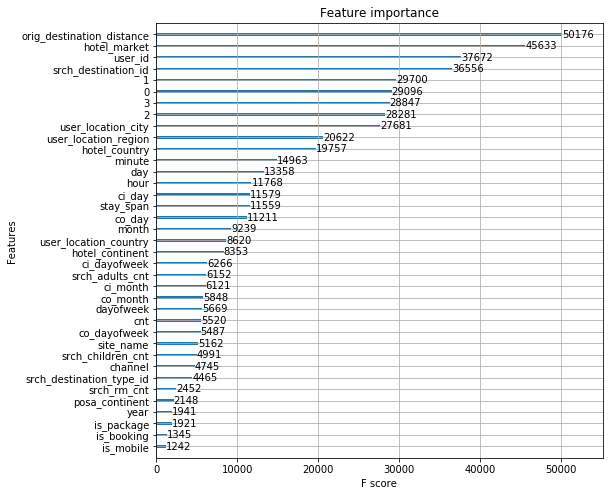

In [38]:
fig, ax = plt.subplots(1, figsize=(8,8))
xgb.plot_importance(model,ax)